In [1]:
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from highlight_text import ax_text, fig_text

### Functions

In [2]:
league_dict = {'eredivisie': 'ned-eredivisie',
               'premier league': 'eng-premier-league',
               'bundesliga': 'bundesliga',
               'ligue 1': 'fra-ligue-1',
               'serie a': 'ita-serie-a'}

def get_url(league, season, week=1):
    league = league_dict.get(league, 'eng-premier-league')
    return f'https://www.worldfootball.net/schedule/{league}-{season-1}-{season}-spieltag/{week}/'

In [3]:
def scrape_standings(league, season=2020):
    week = 1
    standings = []
    while True:
        url = get_url(league, season, week)
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        standings_table = soup.find_all('table', attrs={'class':'standard_tabelle'})[1]
        if 'news' in standings_table.find('td').text or '-:-' in page.text:
            break
        else:
            teams = [team.text for team in standings_table.find_all('a')]
            standings.append(teams)
            week += 1
    
    # Return DataFrame
    return pd.DataFrame(standings).T

In [4]:
def get_patch(p1, p2, color):
    Path = mpath.Path
    x1, y1 = p1; x2, y2 = p2
    
    if y2 > y1:
        patch = mpatches.PathPatch(
            Path(
                 [p1, (x1+(x2-x1)/2, y1), (x1+(x2-x1)/2, y1+(y2-y1)/2), (x1+(x2-x1)/2, y2), p2],
                 [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.CURVE3]),
            ec=color, fc='none', zorder=5)
        
    elif y2 < y1:
        patch = mpatches.PathPatch(
            Path([p1, (x1 + (x2-x1)/2, y1), (x1+(x2-x1)/2, y1+(y2-y1)/2), (x1 + (x2-x1)/2, y2), p2],
                 [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.CURVE3]),
            ec=color, fc='none', zorder=5)
        
    else:
        patch = mpatches.PathPatch(
            Path([p1, p2],
                 [Path.MOVETO, Path.LINETO]), ec=color, fc='none', zorder=5)

    return patch

In [5]:
def plot_crest(x, y, image, ax, zoom=1):
    try:
        image = plt.imread(image)
        im = OffsetImage(image, zoom=zoom)
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0 in zip(x, y):
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists
    except:
        pass

### Scrape and Plot

In [6]:
league = 'ligue 1'
season = 2017

standings = scrape_standings(league, season)
print(f'Scraped {len(standings.columns)} game weeks')

Scraped 38 game weeks


In [7]:
highlight_colors = {'AS Monaco': 'red', 'Paris Saint-Germain': 'blue'}

num_teams = len(standings)
num_games = len(standings.columns)
team_names = standings.iloc[:,-1].to_list()

# Reorder list
for team in highlight_colors.keys():
    team_names.append(team_names.pop(team_names.index(team)))

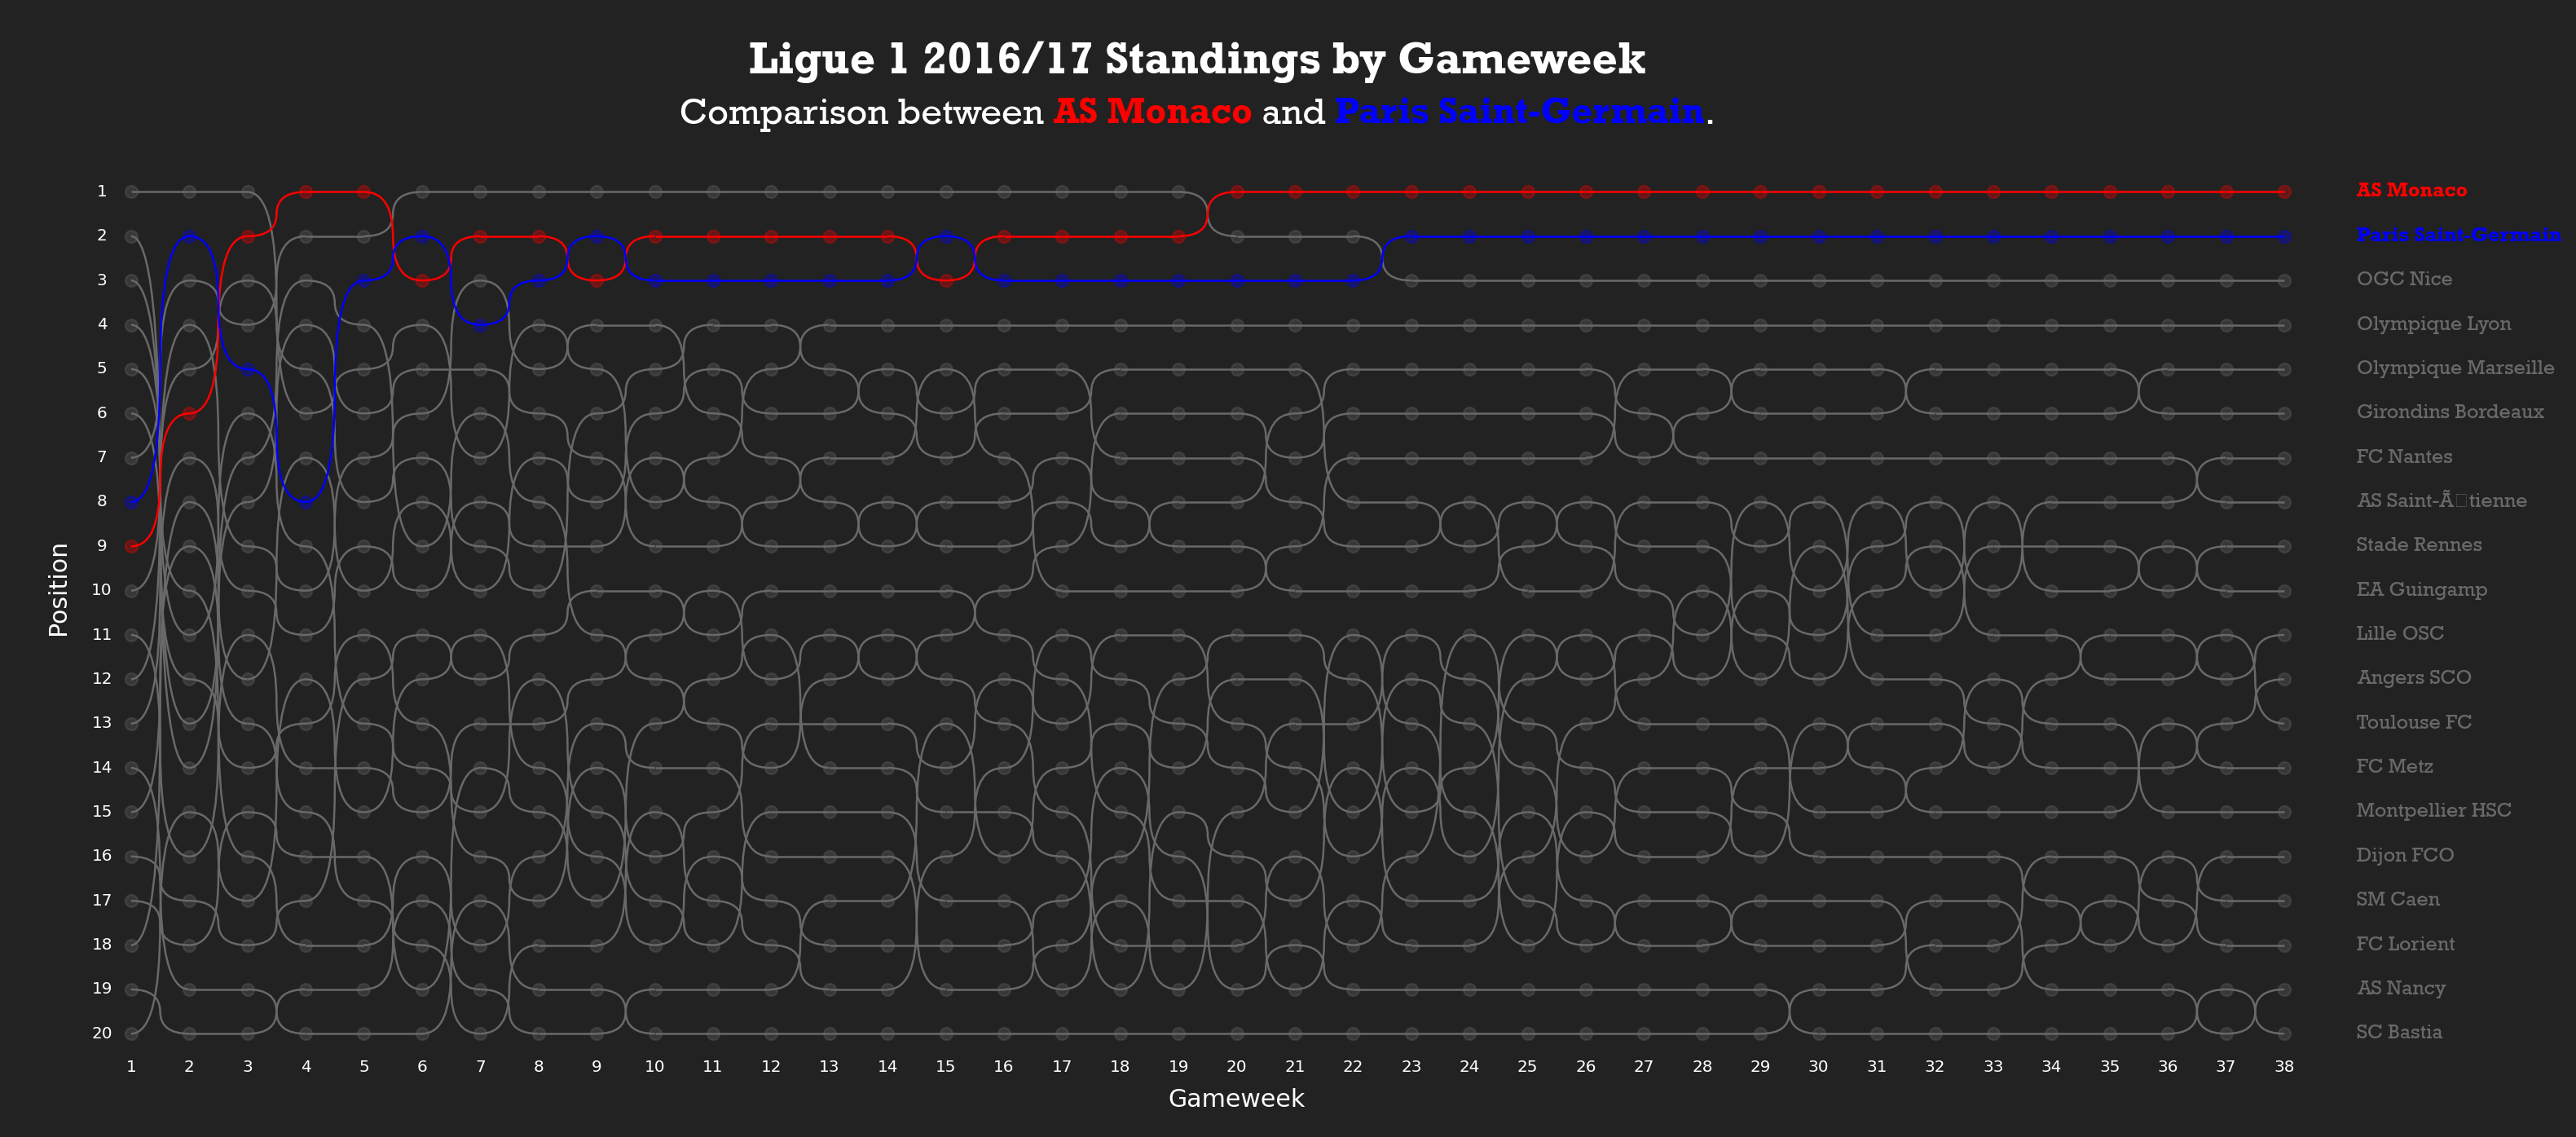

In [8]:
figure_width = 12 + (num_games/4) 
fig, ax = plt.subplots(facecolor='#222222', figsize=(figure_width, 10), dpi=180)

for team_name in team_names:
    # Determine text color and fontweight
    color = highlight_colors.get(team_name, 'dimgrey')
    fontweight = 'bold' if color != 'dimgrey' else None

    indices = standings[standings == team_name].stack().index.tolist()
    coords = [(idx[1], idx[0]) for idx in indices]
    coords = [(int(coord[0]), coord[1]) for coord in coords]
    coords = sorted(coords, key=lambda x: x[0])

    # Plot patches
    for p1, p2 in zip(coords[:-1], coords[1:]):
        patch = get_patch(p1, p2, color=color)
        ax.add_patch(patch)

    for i, j in coords:
        ax.plot(i, j, 'o', color=color, alpha=0.3, zorder=1)

        # Plot team crest
    plot_crest(x=num_games-0.25, y=coords[-1][-1], image=f'crests/{team_name}.png', ax=ax, zoom=0.1)

    # Plot team name
    ax.text(num_games+0.25, coords[-1][-1], team_name, va='center', color=color, fontweight=fontweight, fontname='Rockwell')

# Title
league_title = league.title()
season_title = str(season-1) + '/' + str(season)[2:]
fig.text(0.5, 0.84, f'{league_title} {season_title} Standings by Gameweek', 
         color='w', fontsize=22, fontweight='bold', fontname='Rockwell',
         ha='center',)

# Subtitle
subtitle_teams, subtitle_colors = zip(*highlight_colors.items())
subtitle_teams_hl = [f'<{team}>' for team in  subtitle_teams]
if len(subtitle_teams) == 1:
    subtitle_text = f"{subtitle_teams_hl[0]} highlighted."
elif len(subtitle_teams) == 2:
    subtitle_text = f"Comparison between {' and '.join(subtitle_teams_hl)}."
elif len(subtitle_teams) > 2:
    subtitle_text = f"Comparison between {', '.join(subtitle_teams_hl[:-2])}, {' and '.join(subtitle_teams_hl[-2:])}."

fig_text(x=0.5, y=0.80, s=subtitle_text, color='w',
         highlight_colors=subtitle_colors, highlight_weights='bold',
         fontsize=18, ha='center', fontname='Rockwell')

# Axes labels
ax.text(-1.25, num_teams/2, 'Position', rotation=90, fontsize=12, c='w', va='bottom', ha='center')
ax.text(num_games/2, num_teams+0.5, 'Gameweek', fontsize=12, c='w', va='center', ha='center')

# Tick labels
[ax.text(i-1, num_teams-0.25, i, ha='center', va='center', c='w', size=8) for i in range(1, num_games+1)]
[ax.text(-0.5, i, i+1, ha='center', va='center', c='w', size=8) for i in range(num_teams)] 

ax.set_axis_off()
ax.set_xlim(-2,num_games+2)
ax.set_ylim(-4,num_teams+1)
ax.invert_yaxis()

# Save as PNG
file_name = f"{league.replace(' ', '')}_{season}"
plt.savefig(f"output/{file_name}.png", dpi=300, bbox_inches='tight')

plt.show()